In [1]:
# Read daily files
import glob, pandas as pd
files = glob.glob("Downloads/2023/**/*.csv")

dfs = []

for file in files:
    print(file)
    df_file = pd.read_csv(file, sep=",", index_col=None, header=0)
    dfs.append(df_file)

df = pd.concat(dfs, axis=0, ignore_index=True)

Downloads/2023\07\2023-07-06.csv
Downloads/2023\07\2023-07-07.csv
Downloads/2023\07\2023-07-08.csv
Downloads/2023\07\2023-07-09.csv
Downloads/2023\07\2023-07-10.csv
Downloads/2023\07\2023-07-11.csv
Downloads/2023\07\2023-07-12.csv
Downloads/2023\07\2023-07-13.csv
Downloads/2023\07\2023-07-14.csv
Downloads/2023\07\2023-07-15.csv
Downloads/2023\07\2023-07-16.csv
Downloads/2023\07\2023-07-17.csv
Downloads/2023\07\2023-07-18.csv
Downloads/2023\07\2023-07-19.csv
Downloads/2023\07\2023-07-20.csv
Downloads/2023\07\2023-07-21.csv
Downloads/2023\07\2023-07-22.csv
Downloads/2023\07\2023-07-23.csv
Downloads/2023\07\2023-07-24.csv
Downloads/2023\07\2023-07-25.csv
Downloads/2023\07\2023-07-26.csv
Downloads/2023\07\2023-07-27.csv
Downloads/2023\07\2023-07-28.csv
Downloads/2023\07\2023-07-29.csv
Downloads/2023\07\2023-07-30.csv
Downloads/2023\07\2023-07-31.csv
Downloads/2023\08\2023-08-01.csv
Downloads/2023\08\2023-08-02.csv
Downloads/2023\08\2023-08-03.csv
Downloads/2023\08\2023-08-04.csv
Downloads/

In [2]:
df_keys = \
    df[["Hwsku", "Tenant", "Region"]]\
    .drop_duplicates()\
    .reset_index()

In [3]:
IN_STEPS, OUT_STEPS = 168, 168

In [5]:
# Plotting function

import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import IsolationForest
import os, joblib
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Dense, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

In [6]:
def plot_figure(key, image_title, values, labels, titles, use_subplots=True):
    plt.figure(figsize=(12,5), dpi=100)

    if use_subplots and len(values) > 1:
        fig, axes = plt.subplots(len(values), 1, sharex=True)
    
        for i in range(len(values)):
            axes[i].plot(values[i], label=labels[i])
            axes[i].set_title(titles[i])
            axes[i].legend(loc='upper left', fontsize=8)
    else:
        for i in range(len(values)):
            plt.plot(values[i], label=labels[i])
            
        plt.title(titles[0])
        plt.legend(loc='upper left', fontsize=8)

    folder_path = f"forecasting/plots/{key}"
    
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        
    plt.savefig(os.path.join(folder_path, f"{image_title}.png"))
    plt.show()

In [7]:
def create_dataset(key, dataset_name, data, input_steps=1, output_steps=1):
    Xs, Ys = [], []
    
    for i in range(len(data) - input_steps - output_steps):
        u = data.iloc[i:(i + input_steps)].values
        v = data.iloc[(i + input_steps):(i + input_steps + output_steps)].values
        Xs.append(u)        
        Ys.append(v)

    Xs = np.array(Xs)
    Xs = Xs.reshape(Xs.shape[0], Xs.shape[1], 1)

    Ys = np.array(Ys)
    Ys = Ys.reshape(Ys.shape[0], Ys.shape[1], 1)

    folder_path = f"forecasting/training_data/{key}"
    
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    joblib.dump([Xs, Ys], os.path.join(folder_path, f"{dataset_name}.pickle"))
    
    return Xs, Ys

In [18]:
def model_ts(inp_shape, out_shape):
    inp = Input(shape=inp_shape)
    # (batch, IN_STEPS, 1)
    x = Conv1D(filters=4096, kernel_size=inp_shape[0], activation='relu', input_shape=inp_shape)(inp)
    # (batch, 1, 4096)
    x = Dense(out_shape[0], kernel_initializer=tf.initializers.zeros())(x)
    # (batch, 1, OUT_STEPS)
    out = Reshape(out_shape)(x)
    # (batch, OUT_STEPS, 1)

    model = Model(inp, out)
    model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.001))

    return model

def run_model(key, model_name, model, X_train, y_train, epochs=100, batch_size=32):
    model.fit\
    (
        X_train, 
        y_train, 
        epochs=epochs, 
        batch_size=batch_size, 
        validation_split=None, 
        verbose=0, 
        shuffle=False
    )

    folder_path = f"forecasting/model/{key}"
    
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    model.save(os.path.join(folder_path, f"{model_name}.h5"))

def do_forecast(key, model_name, data):
    path = f"forecasting/model/{key}/{model_name}.h5"
    preds = None
    
    if os.path.exists(path):
        model = load_model(path)
        preds = model.predict(data)

    return preds

In [22]:
def task(key):
    print(key)
    path = f"forecasting/data/{key}.pkl"
    df_one = None
    
    if os.path.exists(path):
        print("Loading saved data...")
        df_one = joblib.load(path)

    if df_one is not None:
        # Select SnapshotTime and PhysicalCores
        df_filt = df_one[["SnapshotTime", "PhysicalCores"]].copy()
        df_filt.rename(columns={"PhysicalCores":"cores"}, inplace=True)
    
        # Replace NULL with 0 values for PhysicalCores
        df_filt.fillna(0, inplace=True)
    
        plot_figure(key, "orig_physical_cores", [df_filt.cores], ["num_cores"], ["Physical Cores"])
    
        # Do FFT transform of the values to get the period of the series
        print("Doing FFT Transform for period calculation...")
        fft = np.fft.rfft(df_filt.cores)
    
        plot_figure(key, "fft_transform", [abs(fft)[1:]], ["frequency"], ["FFT Transform"])
    
        # Find period of series from FFT transformation
        # period of the data is around 168 = 24*7, the values have a weekly
        # cycle and since the data is 1hr window, thus period in number of hours = 7*24 = 168
        
        periods = np.argsort(abs(fft))[::-1][:10]
        period = [p for p in periods if p > 0][0]
        period = int(len(df_filt)/period)+1
        print(period)
    
        # Decompose time series into trend, seasonal and residual components
        print("Doing time series decomposition...")
        result = seasonal_decompose(df_filt.cores, 
                                    model='additive', 
                                    extrapolate_trend='freq', 
                                    period=168)
        print(result.trend)
        print(result.seasonal)
        print(result.resid)
        print(result.observed)
    
        # Plot decomposed time series
    
        plot_figure(key, "series_decomposition", 
                    [result.trend, result.seasonal, result.resid], 
                    ["trend", "seasonality", "residual"], 
                    ["Trend", "Seasonality", "Residual"])
    
        # Perform anomaly detection on residual series.
        # Here we are using the Isolation Forest algorithm
    
        print("Doing anomaly detection on residuals...")
        
        anomaly_data = [[x] for x in result.resid]
        clf = IsolationForest(random_state=0).fit(anomaly_data)
        out = clf.predict(anomaly_data)
    
        # Replace anomaly values with moving average of last 24 hours
    
        print("Replacing anomalies with last 24 hrs MA...")
        
        anomaly_indices = [i for i in range(len(out)) if out[i] == -1]
        anomaly_indices_prev = [[max(0,i-24), max(0,i-1)] for i in anomaly_indices]
        prev_averages = [df_filt["cores"].loc[x:y].mean() for x, y in anomaly_indices_prev]
    
        df_filt.loc[anomaly_indices, "cores"] = prev_averages
    
        plot_figure(key, "anomaly_adjusted_physical_cores", [df_filt.cores], ["num_cores"], ["Physical Cores"])
    
        # Create Training and Test
        print("Creating train test data...")
        
        n = int(0.9*len(df_filt))
        train = df_filt.cores[:n]
        test = df_filt.cores[n:]
    
        train_mean = train.mean()
        train_std = train.std()
        
        train = (train - train_mean) / train_std
    
        X_train, y_train = create_dataset(key, "training", train, IN_STEPS, OUT_STEPS)
    
        print("Training model...")
        model = model_ts(X_train[0].shape, y_train[0].shape)
        run_model(key, "experiment_model", model, X_train, y_train, epochs=100, batch_size=32)
    
        print("Doing prediction with test data...")
        u = train.iloc[-IN_STEPS:].values
        u = np.array(u).reshape(1, IN_STEPS, 1)
        v = model.predict(u)
        v = v[0]*train_std+train_mean

        m = min(test.shape[0], v.shape[0])
    
        plot_figure(key, "actual_vs_forecast", 
                    [test.tolist()[:m], v.tolist()[:m]], 
                    ["actual", "forecast"], 
                    ["Forecast vs Actuals"], 
                    use_subplots=False)
    
        # Train model on entire dataset and save model
        print("Training model on entire data...")
        train = df_filt.cores.copy()
    
        train_mean = train.mean()
        train_std = train.std()
        
        train = (train - train_mean) / train_std
    
        X_train, y_train = create_dataset(key, "full_data", train, IN_STEPS, OUT_STEPS)
        run_model(key, "final_model", model, X_train, y_train, epochs=100, batch_size=32)
    
def do_process(df, hwsku, tenant, region):
    key = hwsku + "___" + tenant + "___" + region
    print(key)

    folder_path = f"forecasting/data"
    
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    # Filter based on Hwsku, Tenant and Region
    print("Filtering based on key...")
    df_one = \
        df\
        [\
            (df.Hwsku == hwsku)&\
            (df.Tenant == tenant)&\
            (df.Region == region)\
        ].reset_index()

    if len(df_one) > 1000:
        joblib.dump(df_one, os.path.join(folder_path, f"{key}.pkl"))
        return key

    return None

In [24]:
import random

keys = []
for i in random.sample(list(range(len(df_keys))), 5):
    _, hwsku, tenant, region = list(df_keys.loc[i])
    res = do_process(df, hwsku, tenant, region)
    if res:
        keys += [res]

amd_lm_mm___ams09prdapp19___europewest
Filtering based on key...
intel_all___pnq22prdapp04___indiacentral
Filtering based on key...
intel_lm_mm___hk2prdapp14___asiaeast
Filtering based on key...
intel_lm_mm___mnz22prdapp30___useast
Filtering based on key...
amd_all___bnz13prdapp08___useast2
Filtering based on key...


amd_lm_mm___ams09prdapp19___europewest
Loading saved data...


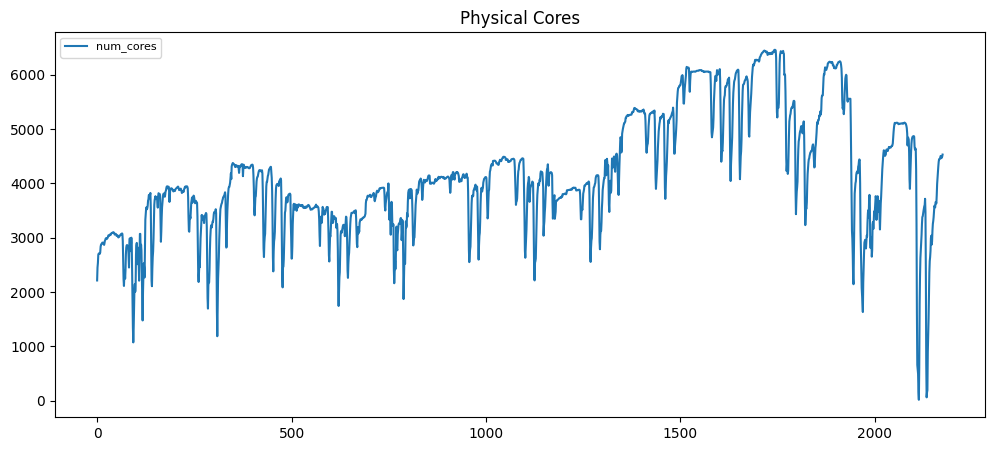

Doing FFT Transform for period calculation...


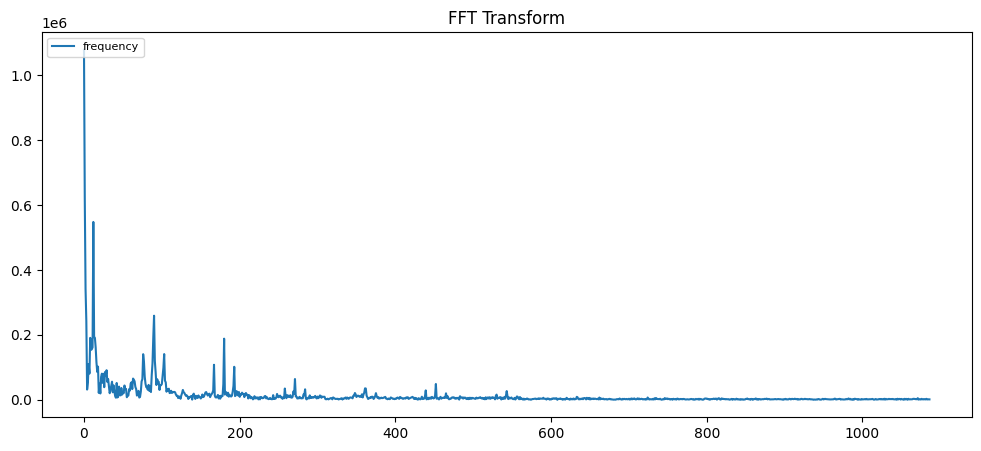

2176
Doing time series decomposition...
0       2716.186511
1       2719.781364
2       2723.376218
3       2726.971072
4       2730.565926
           ...     
2170    3245.801780
2171    3239.883126
2172    3233.964472
2173    3228.045818
2174    3222.127163
Name: trend, Length: 2175, dtype: float64
0      -133.300988
1       -41.068209
2        27.132024
3        94.828141
4       129.186705
           ...    
2170    115.860570
2171    109.642621
2172     84.273287
2173    140.675971
2174    181.204094
Name: seasonal, Length: 2175, dtype: float64
0       -369.596237
1       -227.235727
2       -215.884855
3       -137.002193
4       -152.658693
           ...     
2170    1142.811766
2171    1114.758698
2172    1160.633465
2173    1124.981952
2174    1127.850462
Name: resid, Length: 2175, dtype: float64
0       2213.289286
1       2451.477429
2       2534.623388
3       2684.797020
4       2707.093939
           ...     
2170    4504.474116
2171    4464.284446
2172    4478.871224
21

<Figure size 1200x500 with 0 Axes>

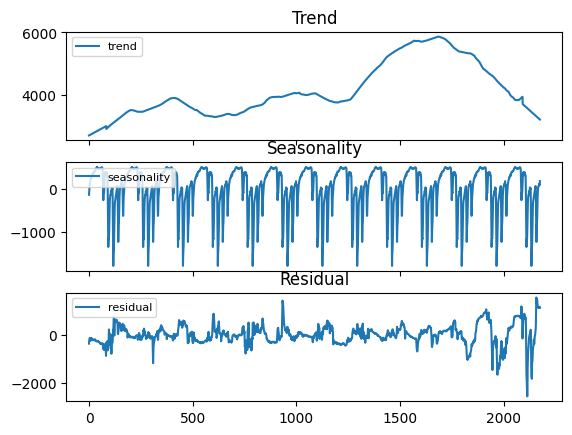

Doing anomaly detection on residuals...
Replacing anomalies with last 24 hrs MA...


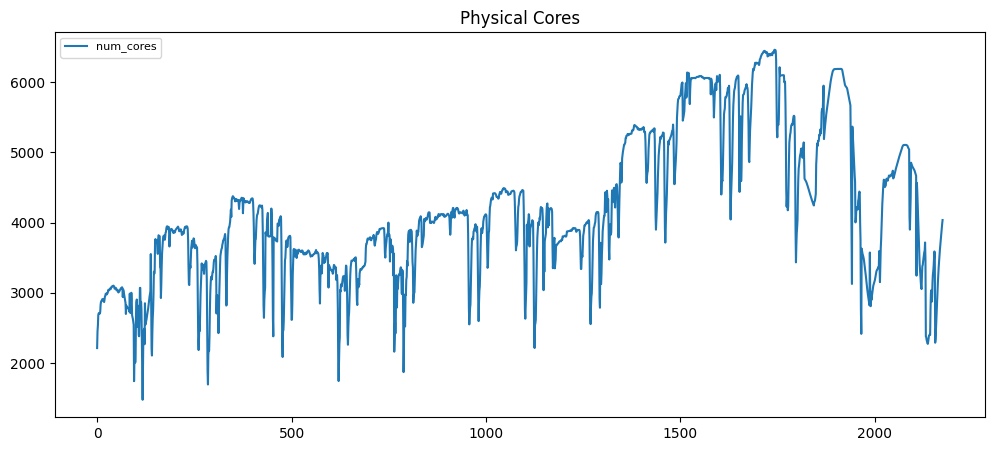

Creating train test data...
Training model...


C:\Users\amondal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Doing prediction with test data...
1/1 [==============================] - 0s 205ms/step


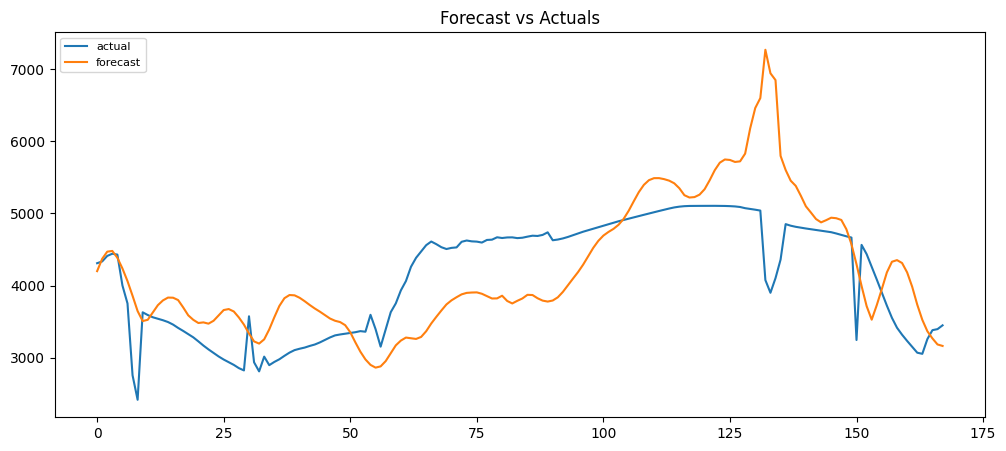

Training model on entire data...
intel_all___pnq22prdapp04___indiacentral
Loading saved data...


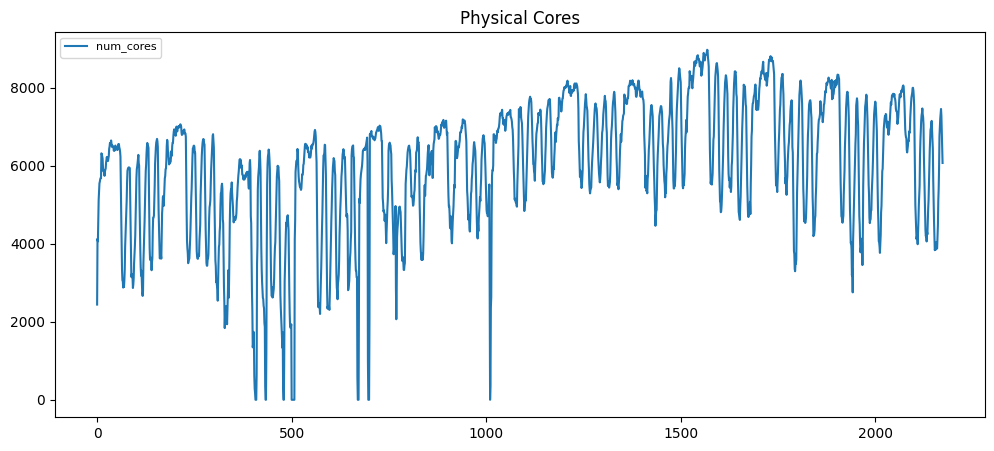

Doing FFT Transform for period calculation...


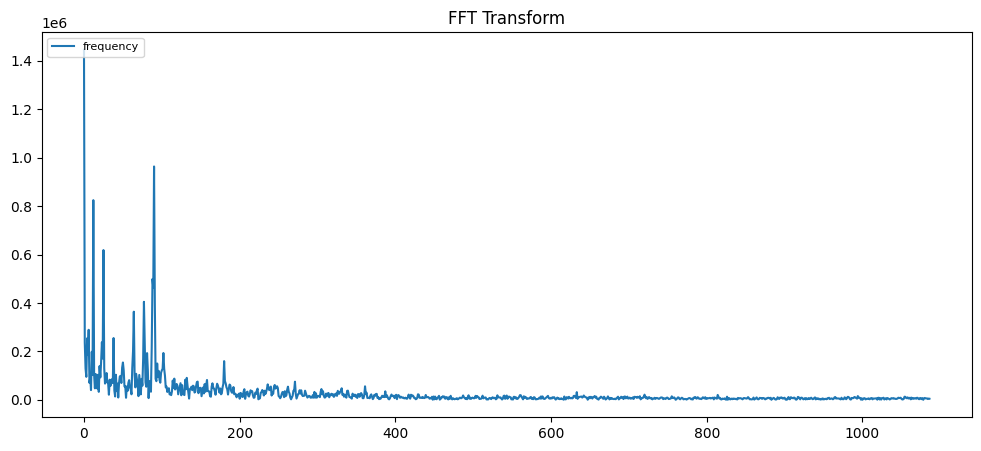

2175
Doing time series decomposition...
0       5004.234694
1       5006.295919
2       5008.357143
3       5010.418368
4       5012.479593
           ...     
2169    6477.541184
2170    6477.828537
2171    6478.115890
2172    6478.403243
2173    6478.690595
Name: trend, Length: 2174, dtype: float64
0      -1655.357812
1      -1310.733301
2      -1164.177457
3      -1154.510783
4       -394.642245
           ...     
2169     990.858918
2170     916.275521
2171     690.125859
2172     494.538047
2173    -130.977073
Name: seasonal, Length: 2174, dtype: float64
0      -909.535673
1       429.572272
2       215.143623
3       783.800962
4       514.850495
           ...    
2169    -17.545936
2170   -121.196985
2171   -287.674753
2172   -419.430835
2173   -280.479181
Name: resid, Length: 2174, dtype: float64
0       2439.341209
1       4125.134890
2       4059.323309
3       4639.708547
4       5132.687843
           ...     
2169    7450.854167
2170    7272.907073
2171    6880.566996
21

<Figure size 1200x500 with 0 Axes>

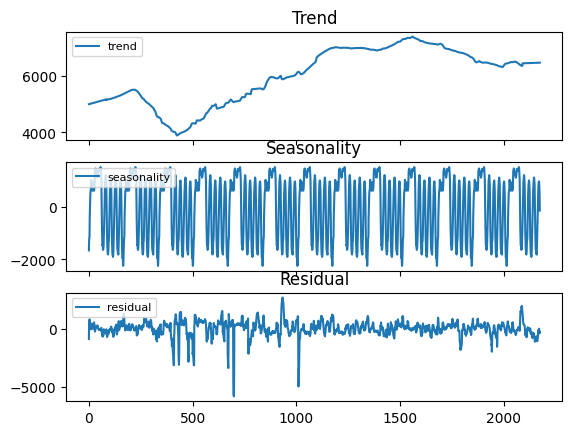

Doing anomaly detection on residuals...
Replacing anomalies with last 24 hrs MA...


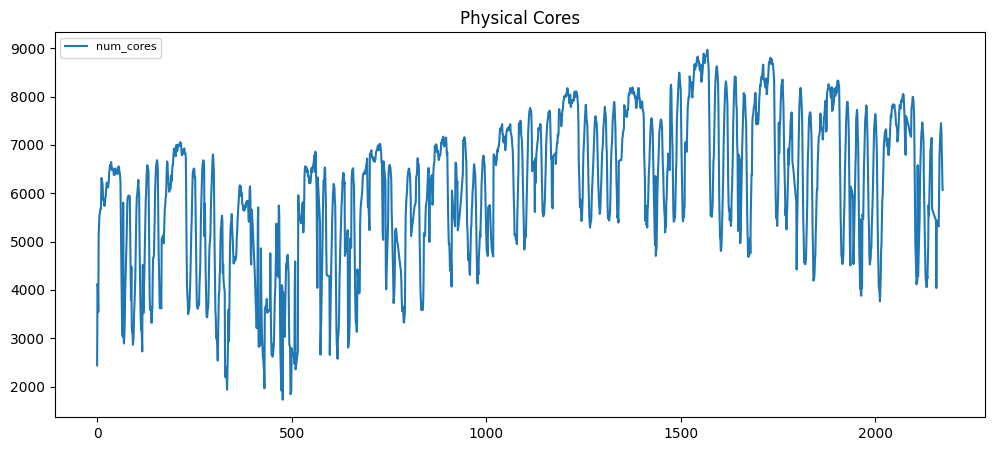

Creating train test data...
Training model...


C:\Users\amondal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Doing prediction with test data...
1/1 [==============================] - 0s 217ms/step


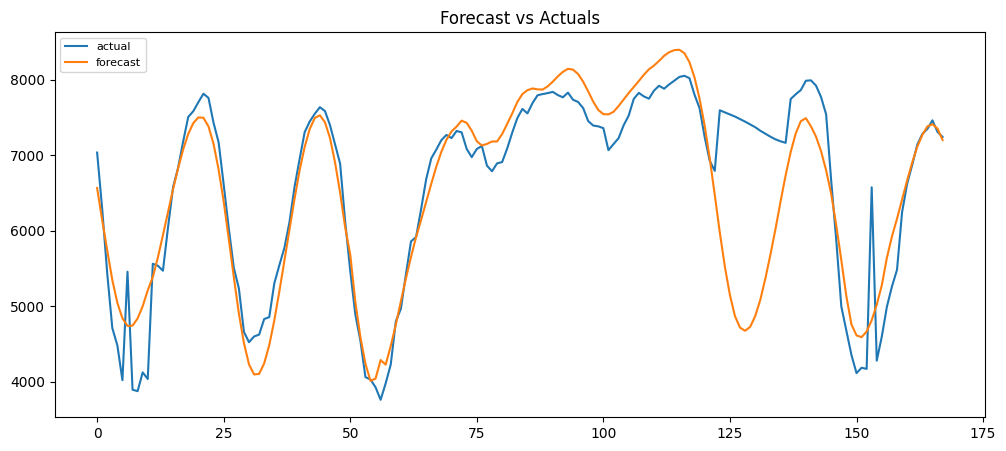

Training model on entire data...
intel_lm_mm___hk2prdapp14___asiaeast
Loading saved data...


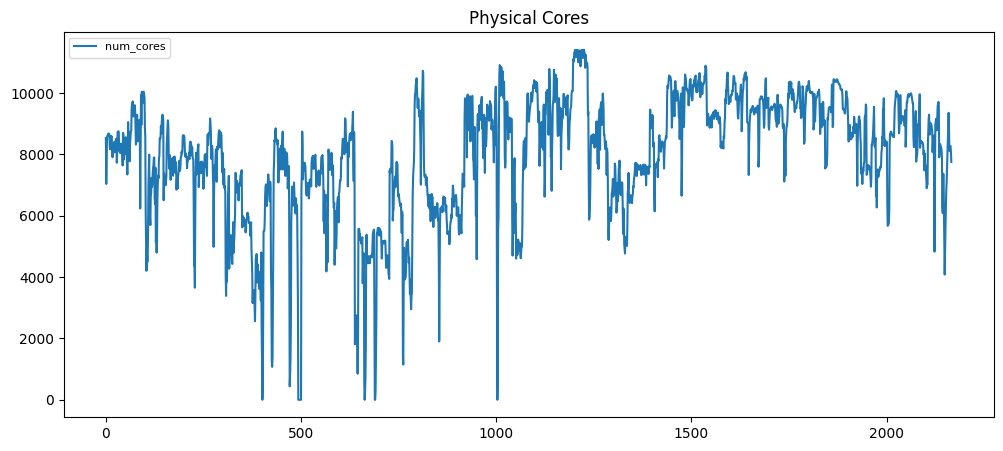

Doing FFT Transform for period calculation...


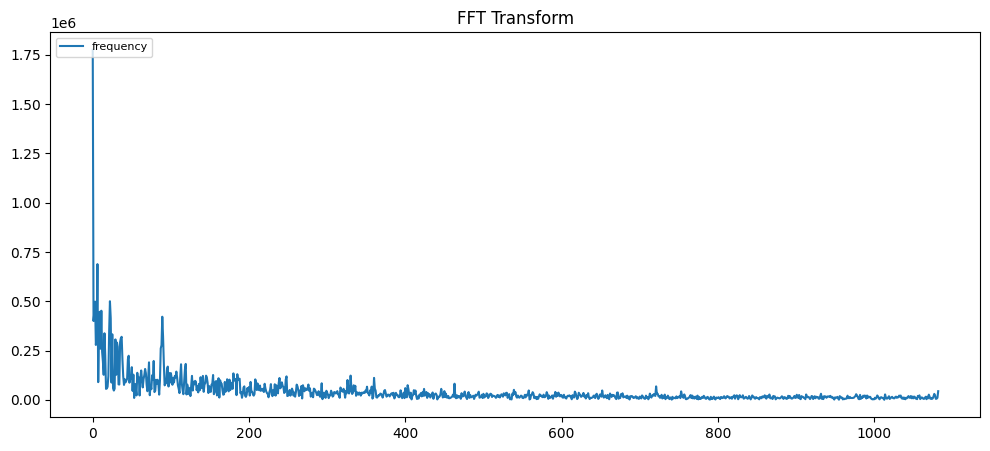

2168
Doing time series decomposition...
0       8296.199655
1       8293.003968
2       8289.808281
3       8286.612593
4       8283.416906
           ...     
2162    8413.840779
2163    8412.721495
2164    8411.602211
2165    8410.482927
2166    8409.363642
Name: trend, Length: 2167, dtype: float64
0       205.118398
1       119.147410
2       223.761681
3       222.616787
4       108.473855
           ...    
2162    454.897772
2163    434.067844
2164   -238.742803
2165   -348.832720
2166   -398.584114
Name: seasonal, Length: 2167, dtype: float64
0         28.084087
1      -1377.858256
2       -627.669123
3         49.771739
4        209.579590
           ...     
2162    -600.452419
2163    -581.371692
2164      99.549314
2165       8.708991
2166    -261.346424
Name: resid, Length: 2167, dtype: float64
0       8529.402139
1       7034.293121
2       7885.900838
3       8559.001119
4       8601.470351
           ...     
2162    8268.286132
2163    8265.417648
2164    8272.408722
21

<Figure size 1200x500 with 0 Axes>

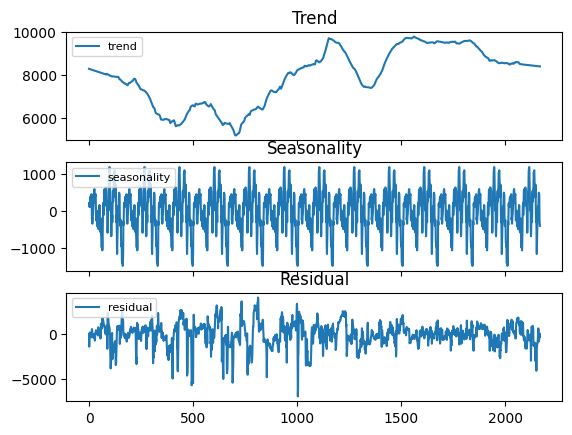

Doing anomaly detection on residuals...
Replacing anomalies with last 24 hrs MA...


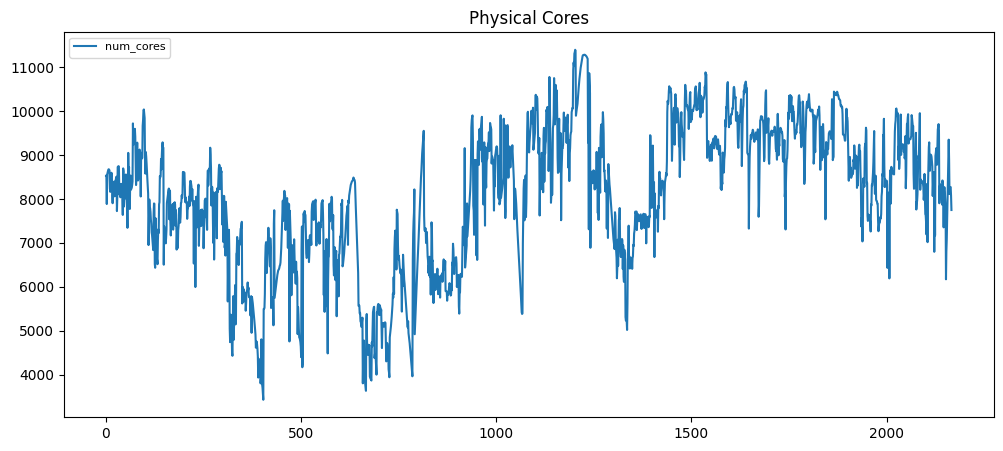

Creating train test data...
Training model...


C:\Users\amondal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Doing prediction with test data...
1/1 [==============================] - 0s 200ms/step


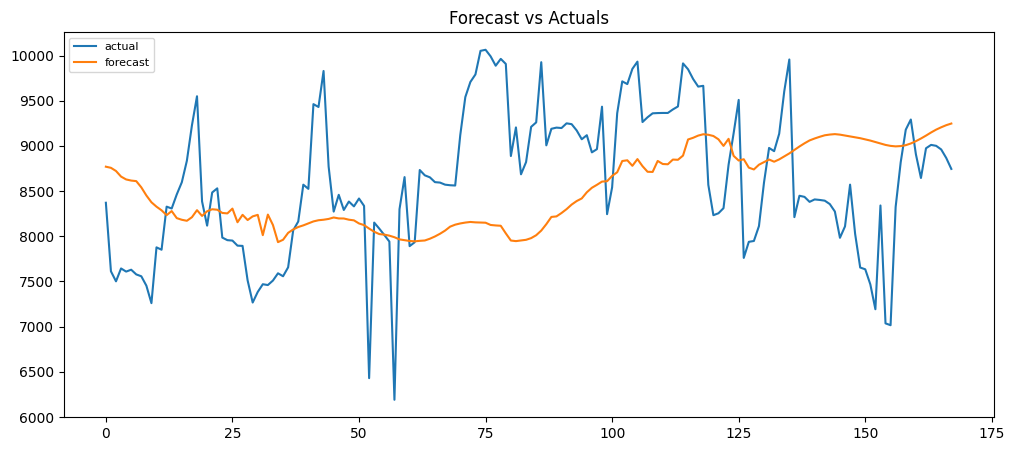

Training model on entire data...
intel_lm_mm___mnz22prdapp30___useast
Loading saved data...


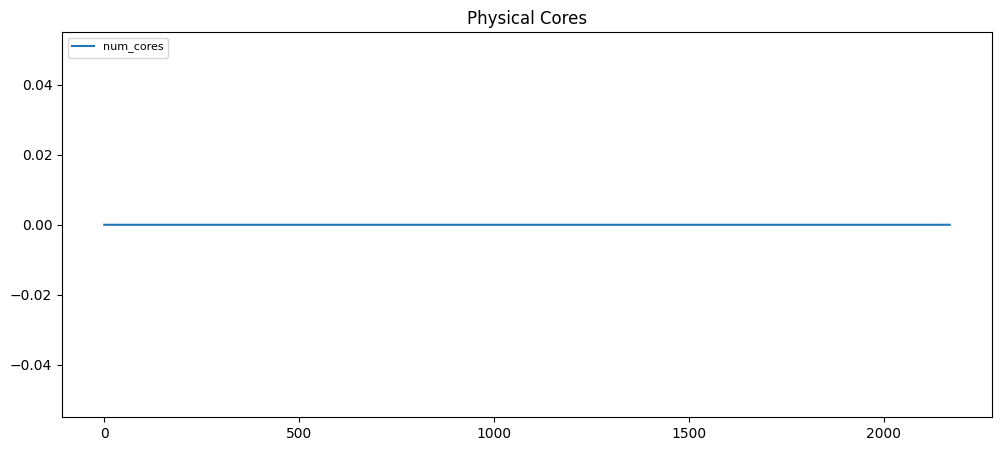

Doing FFT Transform for period calculation...


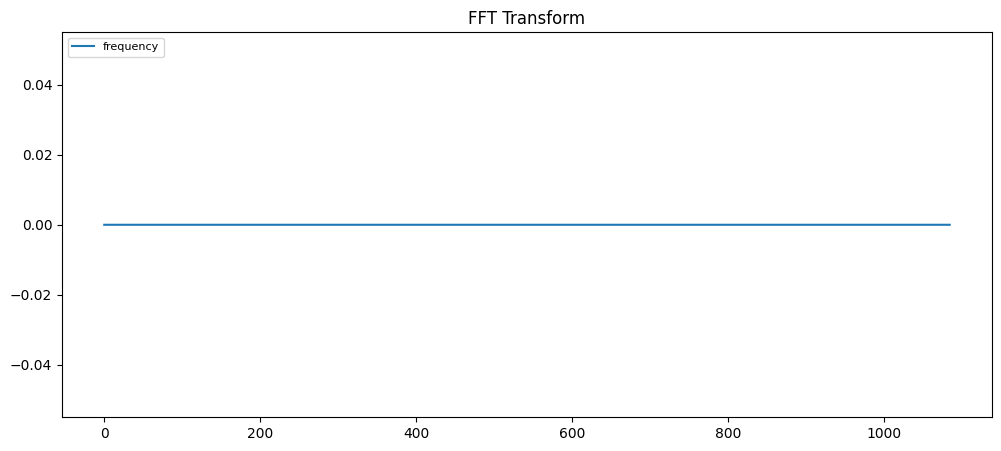

3
Doing time series decomposition...
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
2165    0.0
2166    0.0
2167    0.0
2168    0.0
2169    0.0
Name: trend, Length: 2170, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
2165    0.0
2166    0.0
2167    0.0
2168    0.0
2169    0.0
Name: seasonal, Length: 2170, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
2165    0.0
2166    0.0
2167    0.0
2168    0.0
2169    0.0
Name: resid, Length: 2170, dtype: float64
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
2165    0.0
2166    0.0
2167    0.0
2168    0.0
2169    0.0
Name: cores, Length: 2170, dtype: float64


<Figure size 1200x500 with 0 Axes>

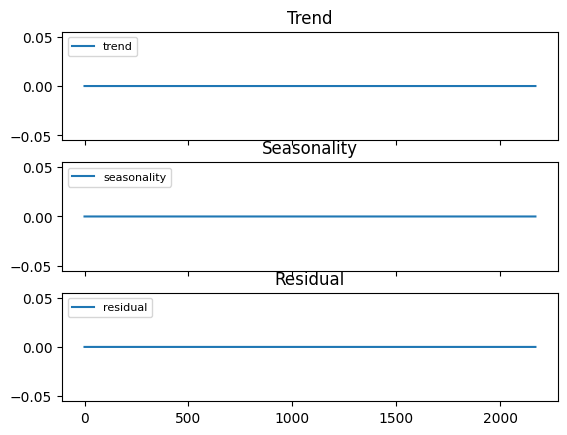

Doing anomaly detection on residuals...
Replacing anomalies with last 24 hrs MA...


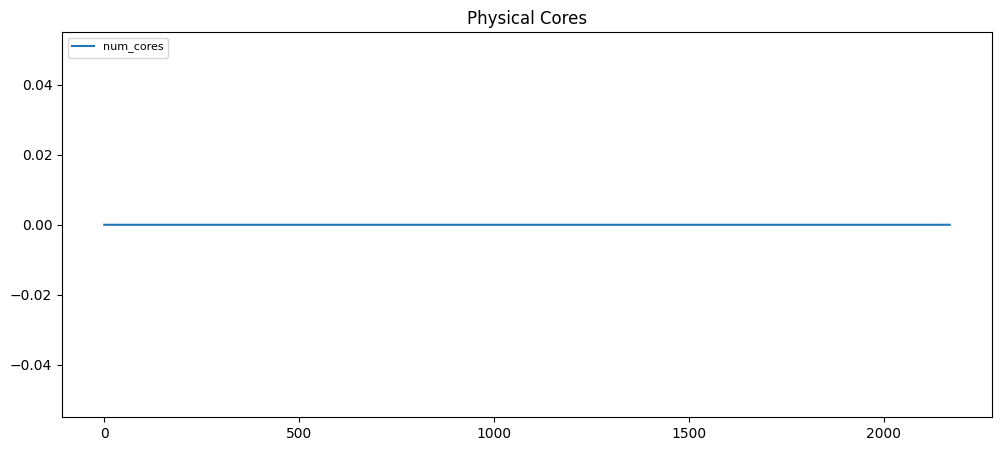

Creating train test data...
Training model...


C:\Users\amondal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Doing prediction with test data...
1/1 [==============================] - 0s 226ms/step


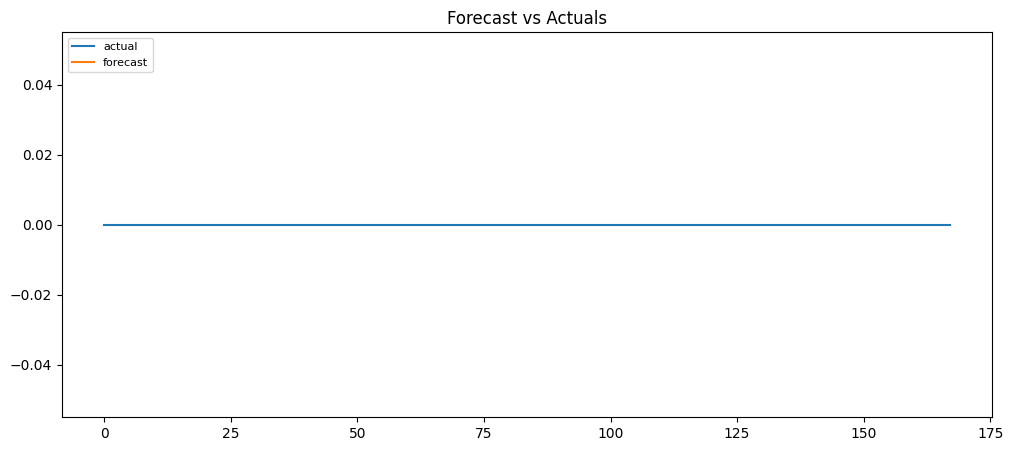

Training model on entire data...
amd_all___bnz13prdapp08___useast2
Loading saved data...


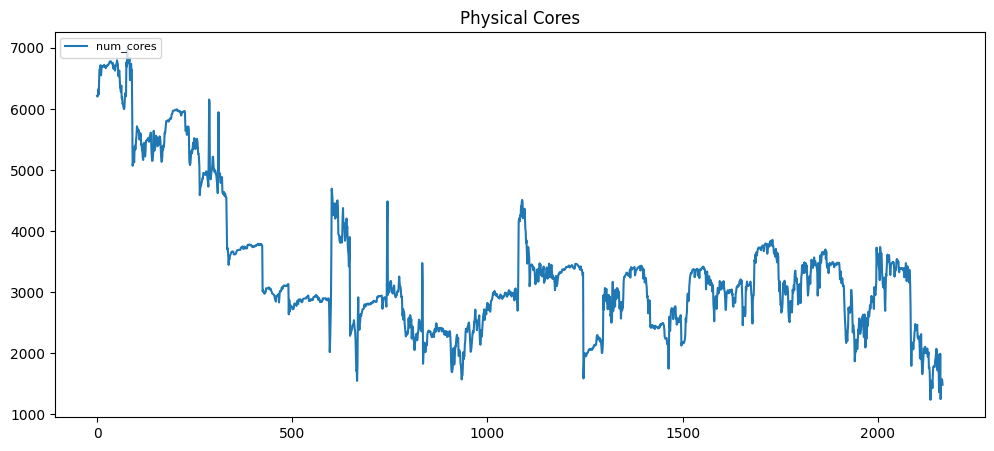

Doing FFT Transform for period calculation...


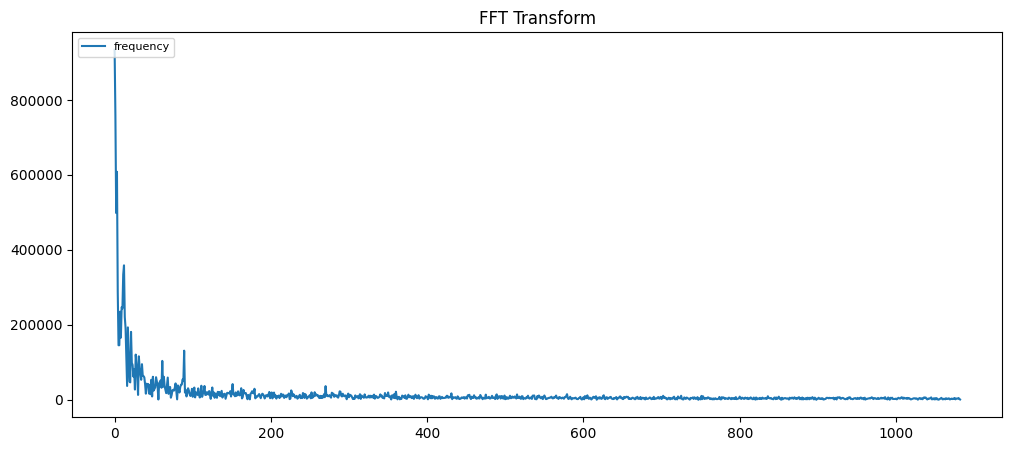

2168
Doing time series decomposition...
0       6351.987294
1       6347.838008
2       6343.688721
3       6339.539435
4       6335.390148
           ...     
2162    2713.922859
2163    2712.649365
2164    2711.375872
2165    2710.102378
2166    2708.828884
Name: trend, Length: 2167, dtype: float64
0      -147.130792
1      -180.124529
2      -186.307822
3      -170.557505
4       -84.581931
           ...    
2162   -254.952284
2163   -236.508296
2164   -222.361650
2165   -126.075724
2166    -72.822557
Name: seasonal, Length: 2167, dtype: float64
0          9.082090
1         34.582807
2         63.999325
3        152.494724
4        -14.758340
           ...     
2162   -1004.582860
2163    -900.323735
2164    -918.494055
2165   -1027.973895
2166   -1152.880327
Name: resid, Length: 2167, dtype: float64
0       6213.938592
1       6202.296286
2       6221.380224
3       6321.476653
4       6236.049878
           ...     
2162    1454.387714
2163    1575.817335
2164    1570.520167
21

<Figure size 1200x500 with 0 Axes>

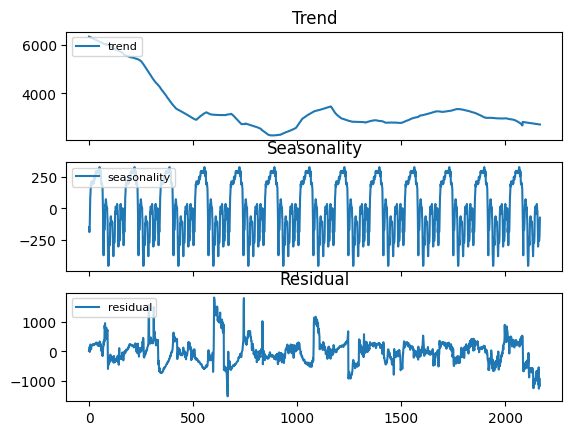

Doing anomaly detection on residuals...
Replacing anomalies with last 24 hrs MA...


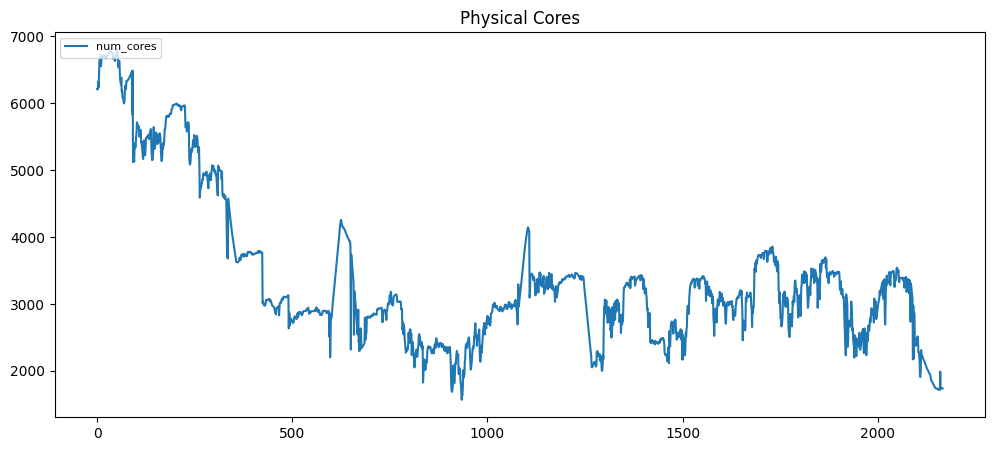

Creating train test data...
Training model...


C:\Users\amondal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Doing prediction with test data...
1/1 [==============================] - 0s 204ms/step


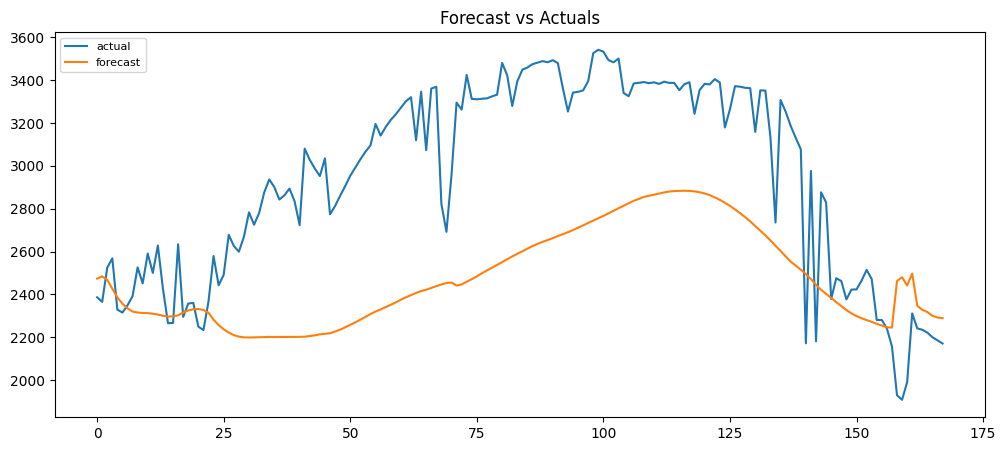

Training model on entire data...


In [25]:
for key in keys:
    task(key)

In [ ]:
# import numpy as np
# x = np.percentile(result.resid, 10)
# y = np.percentile(result.resid, 90)
# out = [1 if (x-1.5*(y-x)) <= z <= (x+1.5*(y-x)) else -1 for z in result.resid]

In [ ]:
from statsmodels.tsa.stattools import adfuller
from numpy import log

result = adfuller(df_filt.cores.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

In [ ]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df_filt.cores); axes[0, 0].set_title('Original Series')
plot_acf(df_filt.cores, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df_filt.cores.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df_filt.cores.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df_filt.cores.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df_filt.cores.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [ ]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df_filt.cores.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df_filt.cores.diff().dropna(), ax=axes[1])

plt.show()

In [ ]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df_filt.cores.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df_filt.cores.diff().dropna(), ax=axes[1])

plt.show()

In [ ]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
n = int(0.9*len(df_filt))
train = df_filt.cores[:n]
test = df_filt.cores[n:]

In [ ]:
import pmdarima as pm

# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(train, 
                       start_p=0, 
                       start_q=0, 
                       test='adf', 
                       max_p=3, 
                       max_q=3, 
                       m=168, 
                       start_P=0, 
                       max_P=3, 
                       start_Q=0, 
                       max_Q=3, 
                       max_D=3, 
                       seasonal=True, 
                       d=1, 
                       D=1, 
                       trace=True, 
                       error_action='ignore',  
                       suppress_warnings=True, 
                       stepwise=True)

smodel.summary()

In [ ]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse})

In [ ]:
preds = smodel.predict(val.shape[0])

In [ ]:
forecast_accuracy(preds, val.values)

In [ ]:
# Forecast
# Make as pandas series
fc_series = pd.Series(preds, index=val.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(val, label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()